In [1]:
from scipy.fftpack import dct
import librosa
import numpy as np
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

## Criando DataFrame com todos os dados

In [ ]:
base_path = "TinySOL/"
instruments_type = ["Brass", "Keyboards", "Strings", "Winds"]
instruments = ["Trombone", "Accordion", "Violin", "Flute"]
instruments_df = []

for instrument_type, instrument in zip(instruments_type, instruments):
    full_path = os.path.join(base_path, instrument_type, instrument, "ordinario/")
    note_value = []
    qct_frequencies_per_note = []

    df_instrument = {
        'instrument_name': instrument
    }
    print(full_path)
    for file in os.listdir(full_path):
        if file.endswith(".wav"):
            note = file.split('-')[2]
            wav_path = os.path.join(full_path, file)
            y, sr = librosa.load(wav_path, sr=None)
            cqt = librosa.cqt(y, sr=sr, n_bins=84, bins_per_octave=12)

            cqt_db = librosa.amplitude_to_db(np.abs(cqt), ref=np.max)

            frequencies = librosa.cqt_frequencies(n_bins=84, fmin=librosa.note_to_hz('C2'))
            top_indices = np.argsort(np.mean(cqt_db, axis=1))[::-1][:12]
            top_frequencies = frequencies[top_indices]

            note_value.append(note)
            qct_frequencies_per_note.append(top_frequencies)

    df_instrument['note'] = note_value
    df_instrument['frequencies'] = qct_frequencies_per_note
    df_instrument = pd.DataFrame(df_instrument)
    instruments_df.append(df_instrument)




instruments_df = pd.concat(instruments_df, ignore_index=True)
sample_df = instruments_df.sample(n=10, random_state=12)
print(instruments_df.shape)
# Sample para analisar as respostas do treinamento
instruments_df = instruments_df.drop(sample_df.index)
print(instruments_df.shape)


TinySOL/Brass/Trombone/ordinario/
TinySOL/Keyboards/Accordion/ordinario/
TinySOL/Strings/Violin/ordinario/
TinySOL/Winds/Flute/ordinario/
(1208, 3)
(1198, 3)


## Dataset balanceamento para detectar o instrumento

In [9]:
print(instruments_df["instrument_name"].value_counts())

min_count = instruments_df["instrument_name"].value_counts().min()

balanced_df = (
    instruments_df.groupby("instrument_name")
    .apply(lambda x: x.sample(n=min_count, random_state=42))
    .reset_index(drop=True)
)

print(balanced_df["instrument_name"].value_counts())

instrument_name
Accordion    684
Violin       281
Flute        117
Trombone     116
Name: count, dtype: int64
instrument_name
Accordion    116
Flute        116
Trombone     116
Violin       116
Name: count, dtype: int64


/tmp/ipykernel_17305/69869211.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_count, random_state=42))


In [4]:
balanced_df.head()

,instrument_name,note,frequencies
0,Accordion,F#6,"[2959.955381693075, 3135.9634878539937, 2793.8..."
1,Accordion,C3,"[261.6255653005986, 783.9908719634986, 277.182..."
2,Accordion,C#7,"[4434.922095629952, 4698.636286678522, 4186.00..."
3,Accordion,B2,"[739.9888454232688, 783.9908719634986, 698.456..."
4,Accordion,G6,"[3135.9634878539937, 3322.4375806395615, 2959...."


In [5]:
print(sample_df.head())

    instrument_name note                                        frequencies
216       Accordion   A5  [1759.9999999999998, 1864.6550460723593, 1661....
791       Accordion   G6  [3135.9634878539937, 3322.4375806395615, 2959....
938          Violin  D#5  [1244.5079348883235, 2489.015869776647, 1174.6...
665       Accordion   F5  [1396.9129257320158, 1479.9776908465376, 1318....
912          Violin   C5  [1046.5022612023945, 1108.730523907488, 987.76...


In [6]:
from sklearn.preprocessing import StandardScaler, LabelEncoder


def calcular_estatisticas(frequencies):
    sorted_freq = sorted(frequencies)
    return {
        'freq_mean': np.mean(sorted_freq),
        'freq_median': np.median(sorted_freq),
        'freq_std': np.std(sorted_freq),
        'freq_min': min(sorted_freq),
        'freq_max': max(sorted_freq),
        'freq_q1': np.quantile(sorted_freq, 0.25),
        'freq_q3': np.quantile(sorted_freq, 0.75),
        'freq_range': max(sorted_freq) - min(sorted_freq)
    }
    
def create_features_instruments(df):
    """
    Processa um DataFrame com colunas: instrument_name, note, frequencies
    Retorna features estatísticas e o target codificado
    """
    
    
    # Aplicar as estatísticas para cada linha
    df_stats = df["frequencies"].apply(calcular_estatisticas).apply(pd.Series)
    
    # Passo 2: Juntar ao DataFrame original
    df = pd.concat([df, df_stats], axis=1)
    
    # Passo 3: Codificar o instrumento
    le = LabelEncoder()
    df["instrument_encoded"] = le.fit_transform(df["instrument_name"])
    
    # Passo 4: Selecionar features e target
    features = [
        'freq_mean', 'freq_median', 'freq_std', 
        'freq_min', 'freq_max', 'freq_q1', 
        'freq_q3', 'freq_range'
    ]
    
    X = df[features]
    y = df["instrument_encoded"]
    
    return X, y, le

## Treinando modelo de indicar o instrumento

In [7]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier


X, y, le = create_features_instruments(balanced_df)

# Divisão em treino (60%), validação (20%) e teste (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalização
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Treinar modelo
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Avaliar na validação (ajuste de hiperparâmetros aqui)
val_accuracy = model.score(X_val, y_val)
print(f"Acurácia na validação: {val_accuracy:.2f}")

# Avaliação final no teste
test_accuracy = model.score(X_test, y_test)
print(f"Acurácia no teste: {test_accuracy:.2f}")

Acurácia na validação: 0.67
Acurácia no teste: 0.75


## Testando no sample.df

In [8]:
X_sample, y_sample, le_sample = create_features_instruments(sample_df)
# 4. Normalizar 
X_sample_scaled = scaler.transform(X_sample) 

# 5. Previsões
predicoes = model.predict(X_sample_scaled)

# 6. Decodificar os rótulos (se usou LabelEncoder)
instrumentos_preditos = le_sample.inverse_transform(predicoes)

# 7. Adicionar as previsões ao novo DataFrame
sample_df["instrument_predito"] = instrumentos_preditos
print(sample_df[["note", "instrument_name", "instrument_predito"]])

     note instrument_name instrument_predito
216    A5       Accordion          Accordion
791    G6       Accordion          Accordion
938   D#5          Violin          Accordion
665    F5       Accordion             Violin
912    C5          Violin           Trombone
1138   C6           Flute              Flute
172   A#7       Accordion          Accordion
374    C6       Accordion             Violin
893   C#6          Violin             Violin
106   G#4        Trombone           Trombone


In [2]:
import os

# Leitura de arquivos
path_folder  = "TinySOL/Strings/Contrabass/ordinario/"
all_path_wav_files = []

# Salvando todos os caminhos arquivos wav
for file in os.listdir(path_folder):
    all_path_wav_files.append(os.path.join(path_folder,file))



In [3]:


# Para cada arquivo wav vamos salvar seu QCT e nome da nota associado a ele
note_value = []
qct_frequencies_per_note = []

for path_wav in all_path_wav_files:
    # O path está salvo como TinySOL/Strings/Contrabass/ordinario/Cb-ord-A1-ff-3c-N
    note = path_wav.split('/')[4].split('-')[2]
   
    y, sr = librosa.load(path_wav, sr=None)
    cqt = librosa.cqt(y, sr=sr, n_bins=84, bins_per_octave=12)

    # Converter a saída para dB
    cqt_db = librosa.amplitude_to_db(np.abs(cqt), ref=np.max)

    # Extrair as 12 maiores frequências com base no dB
    # Obter as frequências correspondentes às bins do CQT
    frequencies = librosa.cqt_frequencies(n_bins=84, fmin=librosa.note_to_hz('C2'))

    # Encontrar os índices das 12 maiores frequências
    top_indices = np.argsort(np.mean(cqt_db, axis=1))[::-1][:12]

    # Frequências e valores de dB correspondentes
    top_frequencies = frequencies[top_indices]
    top_db_values = np.mean(cqt_db[top_indices], axis=1)
    note_value.append(note)
    qct_frequencies_per_note.append(top_frequencies)


In [4]:
def data_augmetation(qct_frequencies_per_note, note_value):
  new_values = qct_frequencies_per_note.copy()
  new_notes = note_value.copy()
  # Para cada nota, vamos gerar outra variação da nota, porém
  # com pelo menos 3 frequencias dela com +2 semitons vamos gerar outra variação da nota
  # e -2 semitons vamos gerar outra variação da nota
  #As notas variam de acordo com o semiton da forma f = f0 * 2^n/12

  for note, dct in zip(note_value, qct_frequencies_per_note):

    for i in range(2):

      exp = (2+i)/12
      dct_1 = [frequency *2**exp for frequency in dct]
      dct_2 = [frequency *2 **(-exp) for frequency in dct]
      new_values.append(dct_1)
      new_notes.append(note)
      new_values.append(dct_2)
      new_notes.append(note)
        
    for i in range(3):
      exp = (2-i)/12
      dct_1 = [frequency *2**exp for frequency in dct]
      dct_2 = [frequency *2 **(-exp) for frequency in dct]
      new_values.append(dct_1)
      new_notes.append(note)
      new_values.append(dct_2)
      new_notes.append(note)
  return new_values, new_notes


In [5]:
print(f'Tamanho dos dados antes {len(qct_frequencies_per_note)} {len(note_value)}')
qct_frequencies_per_note, note_value = data_augmetation(qct_frequencies_per_note, note_value)
print(f'Tamanho dos dados depois {len(qct_frequencies_per_note)} {len(note_value)}')

Tamanho dos dados antes 309 309
Tamanho dos dados depois 3399 3399


In [6]:
X = np.array(qct_frequencies_per_note)
y = np.array(note_value)


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
from sklearn.preprocessing import StandardScaler;

# Scale the training and test matrices
scaler = StandardScaler();
scaler.fit(X_train);
X_train = scaler.transform(X_train);
X_test = scaler.transform(X_test);
print("Classes em y_train:", len(np.unique(y_train)))
print("Classes em y_test:", len(np.unique(y_test)))
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

label_encoder = LabelEncoder()
y_train= label_encoder.fit_transform(y_train)
y_test= label_encoder.transform(y_test)
print(y_train.shape)
print(y_test.shape)

one_hot_encoder = OneHotEncoder(sparse_output=False)
y_train = one_hot_encoder.fit_transform(y_train.reshape(-1, 1))
y_test = one_hot_encoder.transform(y_test.reshape(-1, 1))

# Verificar as formas
print("Forma de y_train_one_hot:", y_train.shape)  # Deve ser (n_samples_train, n_classes)
print("Forma de y_test_one_hot:", y_test.shape)  # Deve ser (n_samples_test, n_classes)
print(y_train.shape)
print(y_test.shape)

Classes em y_train: 45
Classes em y_test: 45
(2719, 12)
(2719,)
(680, 12)
(680,)
(2719,)
(680,)
Forma de y_train_one_hot: (2719, 45)
Forma de y_test_one_hot: (680, 45)
(2719, 45)
(680, 45)


In [8]:
import tensorflow as tf;
from tensorflow.keras.models import Model, Sequential;
from tensorflow.keras.layers import Dense, Activation;

import tensorflow.keras.backend as K
K.clear_session();

def createModel():
  model = Sequential();

  model.add(Dense(units = 256,
                  input_shape = (12,),
                  activation = 'sigmoid',
                  name = 'hidden'));

  model.add(Dense(units = 45,
                  activation = 'softmax',
                  name = 'output'));
  return model;

model = createModel();

from tensorflow.keras import optimizers;
opt = optimizers.Adam(learning_rate = 0.001);

print(model.summary());

model.compile(optimizer = opt,
              loss = 'categorical_crossentropy',
              metrics = ['accuracy']);

2025-04-01 20:44:07.330905: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-01 20:44:07.334534: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-01 20:44:07.342276: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743551047.357465   27104 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743551047.362687   27104 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743551047.373792   27104 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden (Dense)                  │ (None, 256)            │         3,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 45)             │        11,565 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,893 (58.18 KB)

 Trainable params: 14,893 (58.18 KB)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
hist = model.fit(x = X_train,
                 y = y_train,
                 epochs = 100,
                 batch_size = 1,
                 validation_data = (X_test, y_test))

Epoch 1/100


2719/2719 ━━━━━━━━━━━━━━━━━━━━ 3s 816us/step - accuracy: 0.0824 - loss: 3.5818 - val_accuracy: 0.1132 - val_loss: 2.8195
Epoch 2/100
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 2s 764us/step - accuracy: 0.2055 - loss: 2.6393 - val_accuracy: 0.2574 - val_loss: 2.3262
Epoch 3/100
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 2s 760us/step - accuracy: 0.3138 - loss: 2.2173 - val_accuracy: 0.3868 - val_loss: 1.9466
Epoch 4/100
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 2s 747us/step - accuracy: 0.3919 - loss: 1.9223 - val_accuracy: 0.5044 - val_loss: 1.6564
Epoch 5/100
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 2s 751us/step - accuracy: 0.4467 - loss: 1.6964 - val_accuracy: 0.4647 - val_loss: 1.5559
Epoch 6/100
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 2s 781us/step - accuracy: 0.5160 - loss: 1.5132 - val_accuracy: 0.5426 - val_loss: 1.4082
Epoch 7/100
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 2s 755us/step - accuracy: 0.5539 - loss: 1.3515 - val_accuracy: 0.5794 - val_loss: 1.2770
Epoch 8/100
2719/2719 ━━━━━━━━━━━━━━━━━━━━ 2s 727us/step - accuracy: 0.5877 - los

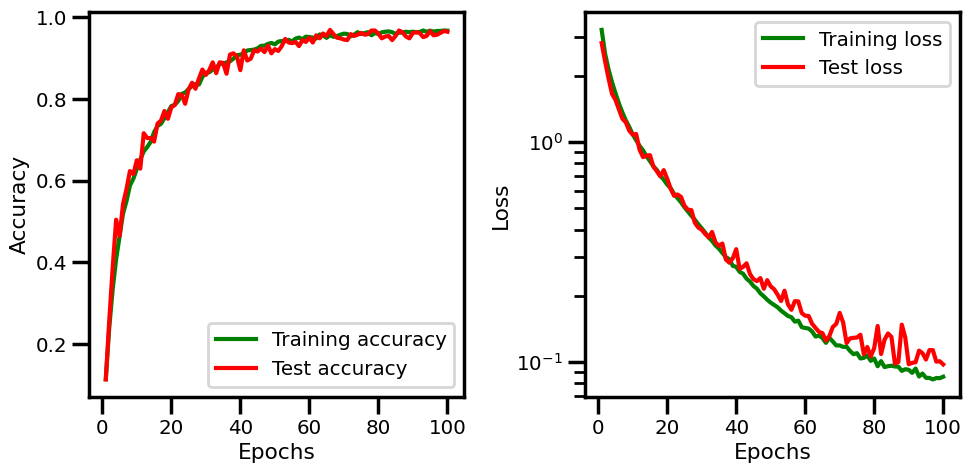

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
# two subplots: one of accuracy vs. epochs, one of loss vs. epochs
# in each subplot, show training in one color and test in another color

trainAcc  = hist.history['accuracy'];
testAcc   = hist.history['val_accuracy'];
trainLoss = hist.history['loss'];
testLoss  = hist.history['val_loss'];
nEpochs   = len(trainAcc);

plt.figure(figsize = (10,5));
sns.set_context("poster", font_scale = .65, rc={"grid.linewidth": 0.6})

# Accuracy Plot
plt.subplot(1,2,1);

sns.lineplot(x     = np.arange(1,nEpochs+1),
             y     = trainAcc,
             label = 'Training accuracy',
             color = 'green');

sns.lineplot(x     = np.arange(1,nEpochs+1),
             y     = testAcc,
             label = 'Test accuracy',
             color = 'red');

plt.xlabel('Epochs');
plt.ylabel('Accuracy');

# Loss Plot
plt.subplot(1,2,2)

sns.lineplot(x     = np.arange(1,nEpochs+1),
             y     = trainLoss,
             label = 'Training loss',
             color = 'green');

sns.lineplot(x     = np.arange(1,nEpochs+1),
             y     = testLoss,
             label = 'Test loss',
             color = 'red');

plt.yscale('log');
plt.xlabel('Epochs');
plt.ylabel('Loss');
plt.tight_layout();


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


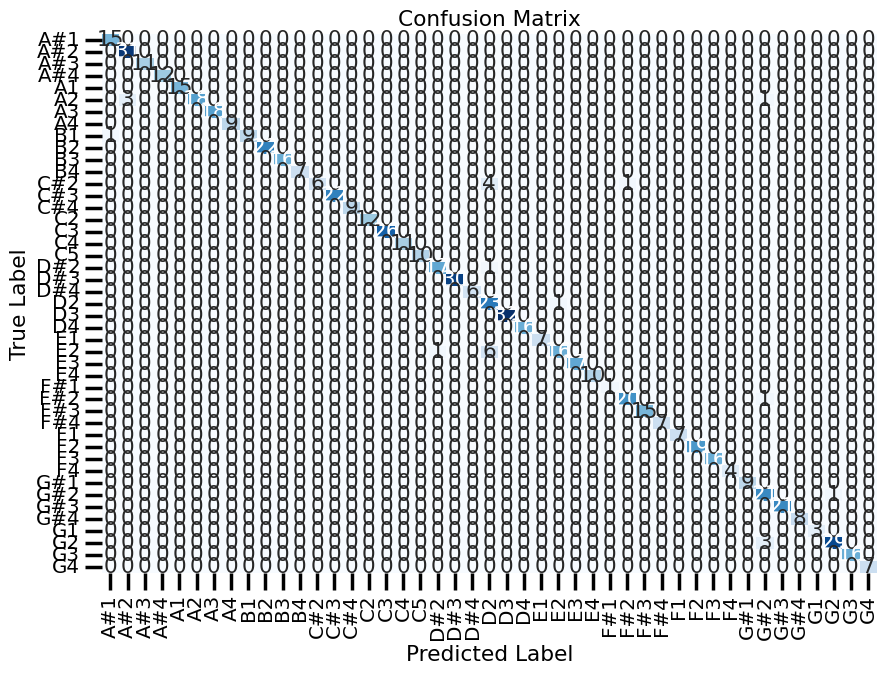

<Figure size 640x480 with 0 Axes>

In [13]:

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)  # Obtém as previsões da rede neural
y_pred_classes = y_pred.argmax(axis=1)  # Converte as previsões de one-hot para classes
y_test_classes = y_test.argmax(axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)
y_test_labels = label_encoder.inverse_transform(y_test_classes)

cm = confusion_matrix(y_test_labels, y_pred_labels)
labels = label_encoder.classes_
# Plotar a matriz de confusão
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=labels, yticklabels=labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()
plt.savefig('confusion.png')

In [ ]:
# Prevendo para Resultados
y, sr = librosa.load("E.wav", sr=None)
cqt = librosa.cqt(y, sr=sr, n_bins=84, bins_per_octave=12)

# Converter a saída para dB
cqt_db = librosa.amplitude_to_db(np.abs(cqt), ref=np.max)

# Extrair as 12 maiores frequências com base no dB
# Obter as frequências correspondentes às bins do CQT
frequencies = librosa.cqt_frequencies(n_bins=84, fmin=librosa.note_to_hz('C2'))

# Encontrar os índices das 12 maiores frequências
top_indices = np.argsort(np.mean(cqt_db, axis=1))[::-1][:84]

# Frequências e valores de dB correspondentes
top_frequencies = frequencies[top_indices]
top_db_values = np.mean(cqt_db[top_indices], axis=1)

# Vamos converter as frequencias de guitarra para contra-baixo
top_frequencies = [frequency/2 for frequency in top_frequencies]
top_frequencies = np.array(top_frequencies).reshape(7,12)

results = [model.predict(top_frequency.reshape(1,-1)) for top_frequency in top_frequencies]



In [ ]:
notes_predicted = []
for result in results:
  predicted_index = np.argmax(result[0])  # Retorna o índice da classe com maior probabilidade
  predicted_label = label_encoder.inverse_transform([predicted_index])
  notes_predicted.append(predicted_label[0])
print(notes_predicted)